# Common Risk Factors in Cryptocurrency

# Master Thesis Project

<div style="text-align: right;font-size: 0.8em">Document Version 1.0.0</div>

This file requires `pandas`, `datetime`, `numpy`, `wand`, `pdf2image`, `Pillow`, and `math` to run. If one of these imports fails, please install the corresponding library and make sure that you have activated the corresponding virtual environment.

The project follows closely the methodology proposed by Liu, Tsyvinski, and Wu (2022) in their paper titled [Common Risk Factors in Cryptocurrency](https://onlinelibrary.wiley.com/doi/abs/10.1111/jofi.13119). Researchers and practitioners can use this paper to check the results of the paper and perhaps retrieve an updated version of the basic findings. They can also use it as a toolbox to use for other projects or to run an extended analysis including further risk factors. Finally, asset management firm may use this code to assess the risk of their portfolio or to firm anomalies in the returns of cryptocurrencies.

For this analysis, I occasionally had to make assumption, for example, regarding the procedure to convert daily to weekly data. This is especially so because the authors of the paper did not provide a detailed enough description of their decisions. There are other, perhabs better ways of doing certain steps and I am always grateful for any feedback that you might provide.

The order of the following sections is closely following the structure of the paper. The outline is:
* <a href="#I._Data">I. Data</a>: The files for all data sources can be found in the data folder. The main blockchain trading data is retrieved from CoinGecko (coingecko_data.py). It is advisable to download the cryptocurrency data set in smaller chunks (for example, 100 cryptocurrencies), since the data set is relatively large and takes long to download due to the API limit. The merge_data.py file can then be used to merge all individal cryptocurrency data files into one large file that is supposed to be loaded into the code below. The daily crptocurrency (aka coin) data is converted to weekly returns using the last available prices: $$r_t = \frac{p_t-p_{t-1}}{p_{t-1}}$$ One can also compute log-returns instead. The definition of the weeks is as follows: The first 7 days of a given year are the first week. The following 50 weeks consist of 7 days each. The last week has either 8 or 9 days (if the year is a leap year). The code below computes the weekly trading data (inclduing returns) and the weekly market returns. Moreover, it generates the first table of the paper. Consequently, 3 time series graphs plotting the returns of Bitcoin, Ripple, and Ethereum against the market returns is shown.

* <a href="#II._Cross-Sectional_Return_Predictor">II. Cross-Sectional Return Predictors</a>:
    * <a href="#A._Size_Characteristics">A. Size Characteristics</a>:
    * <a href="#B._Momentum_Characteristics">B. Momentum Characteristics</a>:
    * <a href="#C._Volume_Characteristics">C. Volume Characteristics</a>:
    * <a href="#D._Volatility_Characteristics">D. Volatility Characteristics</a>:
    * <a href="#E._Insignificant_Strategies">E. Insignificant Strategies</a>:

<a id="I._Data"></a> 
# I. Data

The individual data files already exist.
The data was already merged into a single file.
There are 1814 coins in the data set.
The data has already been converted.
The returns have already been computed.
The market returns data has already been computed.


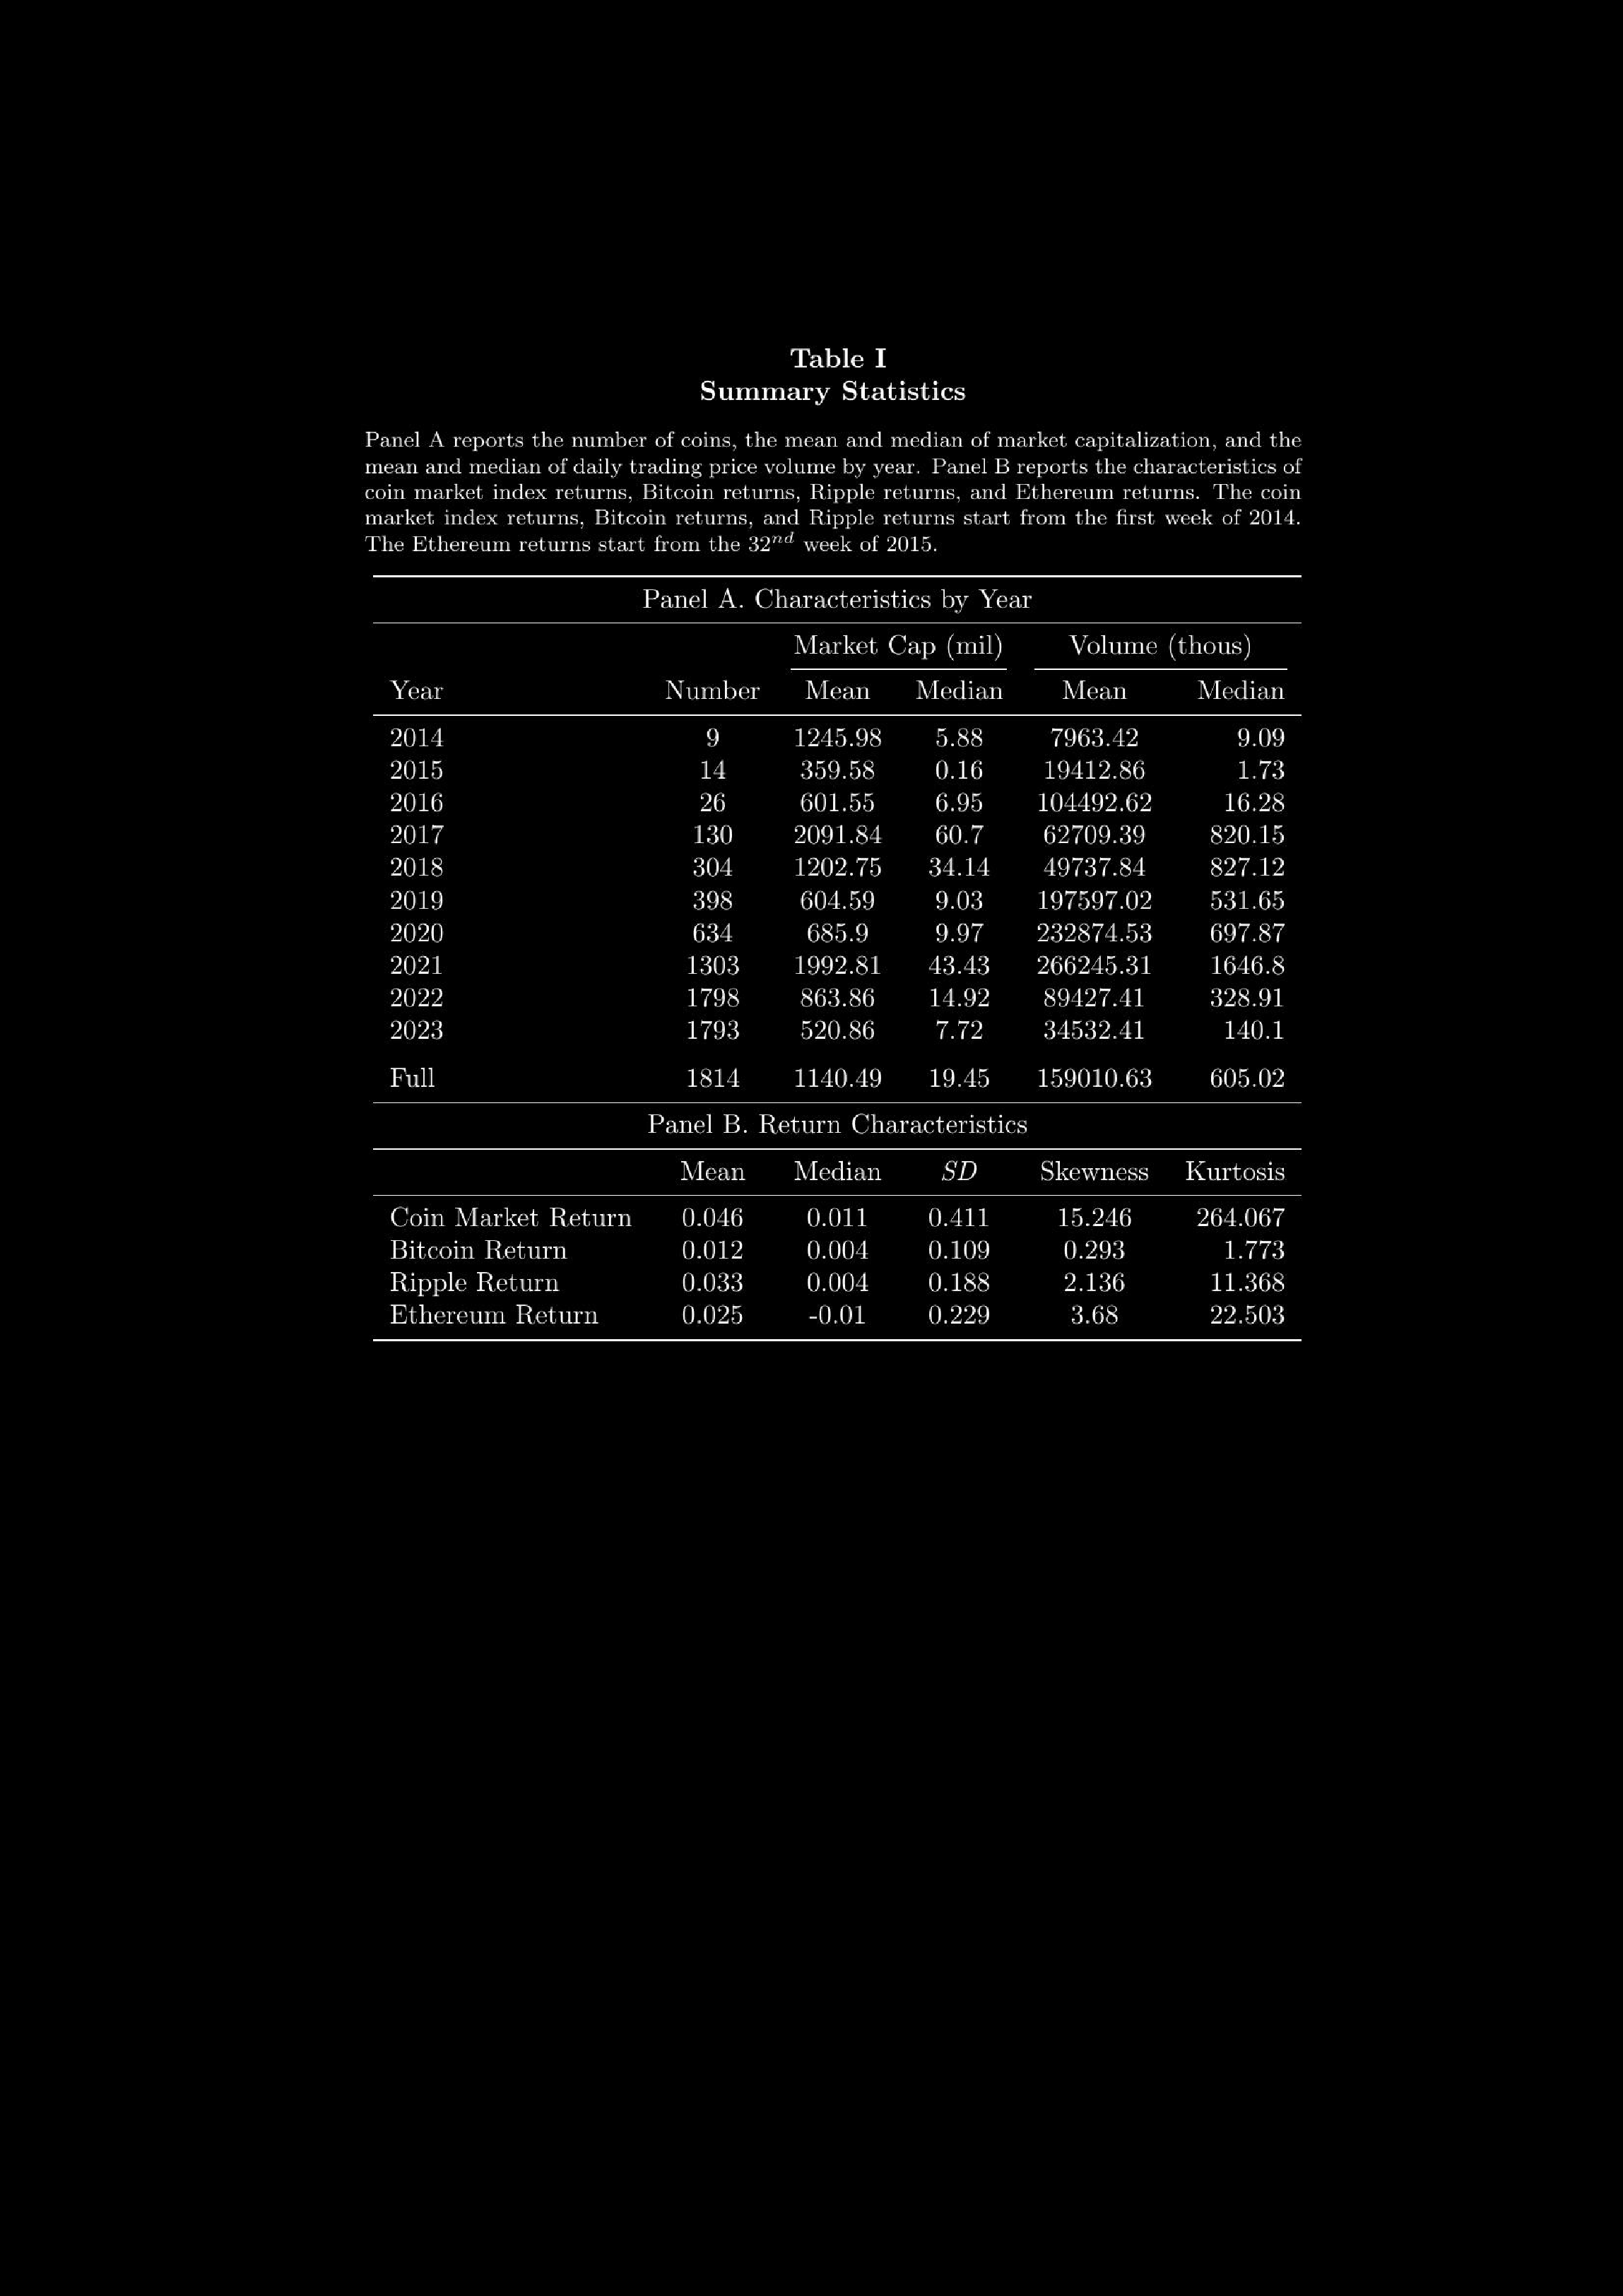

In [1]:
import pandas as pd, datetime, numpy as np, math, time, os
pd.options.mode.chained_assignment = None
from wand.image import Image
# and other modules from the directory
import convert_frequency, data.coingecko_data as coingecko_data, merge_data, render

# specify the data range for the analysis
# in the paper, the authors start on 2014-01-01 due to data availability
start_date = "2014-01-01"
end_date = str(datetime.date.today())

# select the path to the directory where you want to store the data
data_path = r"/Users/Marc/Desktop/Past Affairs/Past Universities/SSE Courses/Master Thesis/Data"

# downloading the data from CoinGecko.com and storing it in smaller data subsets at the specified location
# the data contains daily prices, market caps, and trading volumes
# this step can take up to 2 days due to the API traffic limit
# we are also always checking if the subsequent files already exist (/cg_data.csv, /cg_weekly_data.csv, /cg_weekly_returns.csv, /market_weekly_returns.csv)
# this helps in case the previous files have been deleted
if not os.path.exists(data_path + "/coingecko") and not os.path.exists(data_path + "/cg_data.csv") and not os.path.exists(data_path + "/cg_weekly_data.csv") and not os.path.exists(data_path + "/cg_weekly_returns.csv") and not os.path.exists(data_path + "/market_weekly_returns.csv"):
    coingecko_data.retrieve_data(start_date, end_date, path=data_path)
else:
    print("The individual data files already exist.")

# merging the data subsets and storing the result at the specified location
# this task also absorbs part of the preprocessing, so it's recommended to run this step in any case 
# this step can take up to 12 hours
if not os.path.exists(data_path + "/cg_data.csv") and not os.path.exists(data_path + "/cg_weekly_data.csv") and not os.path.exists(data_path + "/cg_weekly_returns.csv") and not os.path.exists(data_path + "/market_weekly_returns.csv"):
    merge_data.merge(start_date, end_date, path=data_path)
else:
    print("The data was already merged into a single file.")

# the data was retrieved on 2023-01-13
daily_trading_data = pd.read_csv(data_path+"/cg_data.csv")

# all unique coin IDs
coin_ids = pd.unique(daily_trading_data["id"])
print("There are " +str(len(coin_ids)) + " coins in the data set.")

# downloading the data since the conversion process might also take a long time
# if the file for weekly data does not already exist
if not os.path.exists(data_path + "/cg_weekly_data.csv") and not os.path.exists(data_path + "/cg_weekly_returns.csv") and not os.path.exists(data_path + "/market_weekly_returns.csv"):
    print("The data is being transformed into weekly data.")
    # converting the data subset for every coin into weekly frequency
    dfs = []
    percentage_counter = 1
    print("The conversion progress is: ")
    for coin_id in coin_ids:
        # printing the progress 
        progress = int(len(dfs) / len(coin_ids) * 100)
        if progress > percentage_counter:
            percentage_counter += 1
            print(str(progress) + "%")
        # get all the data for one coin
        coin_daily_trading_data = daily_trading_data[daily_trading_data["id"] == coin_id]
        # now we compute the weekly data
        # the function weekly_data is designed to perform this transformation for a single coin at a time
        # this step takes a long time since the data set has a large size
        coin_weekly_data = convert_frequency.weekly_data(coin_daily_trading_data, start_date, end_date, download=False)
        dfs.append(coin_weekly_data)
        
    # combining all dataframes in the dfs list
    weekly_trading_data = pd.concat(dfs)
    # downloading the data
    weekly_trading_data.to_csv(data_path + "/cg_weekly_data.csv", index=False)
else:
    # next, we need to load the data and "unwrap" it again
    print("The data has already been converted.")
    weekly_trading_data = pd.read_csv(data_path + "/cg_weekly_data.csv")

# downloading the data since the returns computation process might also take a long time
# if the file for weekly returns data does not already exist
if not os.path.exists(data_path + "/cg_weekly_returns_data.csv") and not os.path.exists(data_path + "/market_weekly_returns.csv"):
    print("The returns are being computed.")
    # converting the data subset for every coin into weekly frequency
    dfs = []
    percentage_counter = 1
    print("The conversion progress is: ")
    for coin_id in coin_ids:
        # printing the progress 
        progress = int(len(dfs) / len(coin_ids) * 100)
        if progress > percentage_counter:
            percentage_counter += 1
            print(str(progress) + "%")
        coin_weekly_prices = weekly_trading_data[weekly_trading_data["id"] == coin_id]
        # we are losing the first week, since we do not have a previous week for the first week (first week of 2014)
        coin_weekly_returns = [np.nan]
        # the indices of the dataframe for the respective coin
        indices = list(coin_weekly_prices.index)
        if len(coin_weekly_prices) > 2:
            for i in range(len(coin_weekly_prices) - 1):
                # to retrieve the actual indices
                this_week_index = indices[i]
                next_week_index = indices[i + 1]
                try:
                    weekly_return = (coin_weekly_prices["price"][next_week_index] - coin_weekly_prices["price"][this_week_index]) / coin_weekly_prices["price"][this_week_index]
                    # alternatively, the log-return can be computed as follows (math.log() is the natural logarithm by default):
                    # weekly_log_return = math.log(coin_weekly_prices["price"][i + 1] / coin_weekly_prices["price"][i])
                    coin_weekly_returns.append(weekly_return)
                except:
                    # this exception occurs when either current or future price are NaN
                    coin_weekly_returns.append(np.nan)
        # adding the return column to the previous date column
        coin_weekly_prices["return"] = coin_weekly_returns
        dfs.append(coin_weekly_prices)
    # combining all dataframes in the dfs list
    coins_weekly_returns = pd.concat(dfs)
    # downloading the data
    coins_weekly_returns.to_csv(data_path + "/cg_weekly_returns_data.csv", index=False)
else:
    # next, we need to load the data and "unwrap" it again
    print("The returns have already been computed.")
    coins_weekly_returns = pd.read_csv(data_path + "/cg_weekly_returns_data.csv")

coins_weekly_returns_old = coins_weekly_returns
# storing the data in a dict with keys for the ID
coins_weekly_returns = {}
for coin_id in coin_ids:
    # get all the data for one coin
    coins_weekly_returns[coin_id] = coins_weekly_returns_old[coins_weekly_returns_old["id"] == coin_id]

# downloading the data since the returns computation process might also take a long time
# if the file for weekly returns data does not already exist
if not os.path.exists(data_path + "/market_weekly_returns.csv"):
    # constructing the cryptocurrency market returns
    years = []
    weeks = []
    market_returns = []
    included_ids = []
    # taking an arbitrary ID to loop through all weeks
    for i in coins_weekly_returns[coin_ids[0]].index:
        year = coins_weekly_returns[coin_ids[0]]["year"][i]
        years.append(year)
        week = coins_weekly_returns[coin_ids[0]]["week"][i]
        weeks.append(week)
        returns = []
        market_caps = []
        # to keep track of which and how many coins are included for every week
        weekly_included_ids = []
        for coin_id in coin_ids:
            coin_weekly_returns = coins_weekly_returns[coin_id]
            coin_weekly_data = coin_weekly_returns[(coin_weekly_returns["year"] == year) & (coin_weekly_returns["week"] == week)]
            # ignoring all NaNs
            # the most convenient way to check if no cell value are NaN is by applying .isna().sum().sum()
            if coin_weekly_data.isna().sum().sum() == 0:
                # the ID is included
                weekly_included_ids.append(coin_id)
                returns.append(coin_weekly_data["return"].tolist()[0])
                market_caps.append(coin_weekly_data["market_cap"].tolist()[0])
        # if all returns are NaN (for example, in the first week of the time period considered)
        if len(returns) == 0:
            # if no value was added
            market_returns.append(np.nan)
            included_ids.append(np.nan)
        else:
            # for every week add the value-weighted market return (the sumproduct of the returns and the market caps divided by the sum of the market caps) and the included coin IDs
            weighted_average = (sum(x * y for x, y in zip(returns, market_caps)) / sum(market_caps))
            market_returns.append(weighted_average)
            included_ids.append(weekly_included_ids)
    market_weekly_returns = pd.DataFrame({"year": years, "week": weeks, "average_return": market_returns, "included_ids": included_ids})
    # downloading the data
    market_weekly_returns.to_csv(data_path + "/market_weekly_returns.csv", index=False)
else:
    # next, we need to load the data and "unwrap" it again
    print("The market returns data has already been computed.")
    market_weekly_returns = pd.read_csv(data_path + "/market_weekly_returns.csv")

# inverting the colors in the PDF in case the user is using dark mode
if input("Is your editor is dark mode? y/n ") in ["Y", "y"]:
    invert = True
else:
    invert = False

# creates a temporary PDF file named "cover.pdf"
# repeating the process overwrites the file
# we need also the daily data since Panel A is built on daily data
# this step takes about 1 hour
render.render_summary_statistics(start_date, end_date, daily_trading_data, market_weekly_returns, coins_weekly_returns, invert=invert)

pdf_path = os.getcwd() + "/cover.pdf"
# printing the PDF
# this code has to be in the main file
img = Image(filename=pdf_path, resolution=100)
img

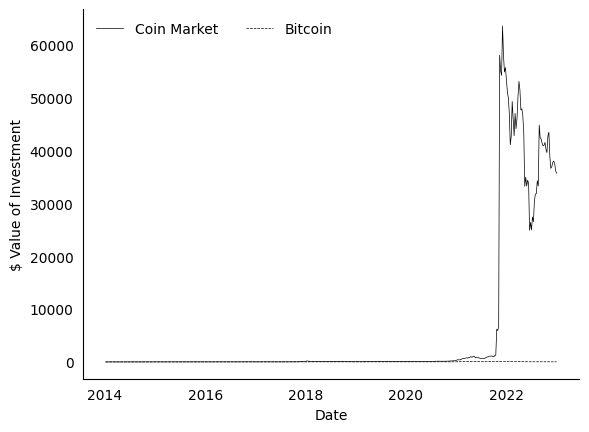

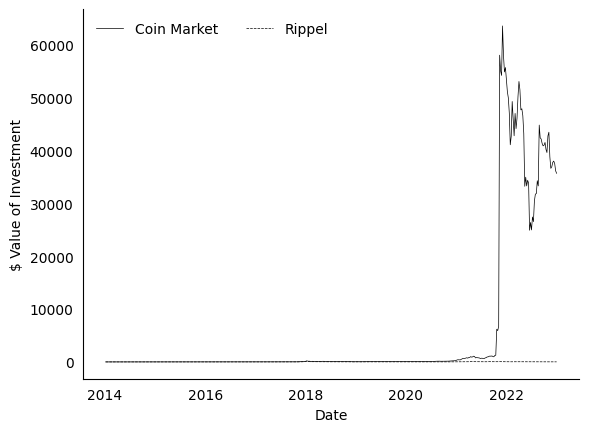

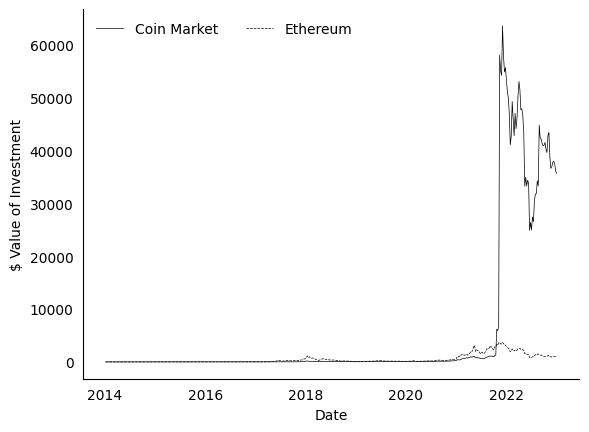

Figure 1. Cryptocurrency market and major coins. This figure plots the aggregate cryptocurrency market against Bitcoin, Ripple, and Ethereum.


In [4]:
# plotting the time series graphs
import matplotlib.pyplot as plt, datetime, numpy as np, math

bitcoin_weekly_returns = coins_weekly_returns["bitcoin"]
ripple_weekly_returns = coins_weekly_returns["ripple"]
ethereum_weekly_returns = coins_weekly_returns["ethereum"]

# %U assumes Monday as first day of the week
year_and_week = market_weekly_returns["year"].astype(int) + market_weekly_returns["week"].astype(int) / 52

index = 1
market_index = []
for market_return in market_weekly_returns["average_return"]:
    if not math.isnan(market_return):
        index *= (1 + market_return)
        market_index.append(index)
    else:
        # if a value is missing add the previous index
        market_index.append(index)
index = 1
bitcoin_index = []
for bitcoin_return in bitcoin_weekly_returns["return"]:
    if not math.isnan(bitcoin_return):
        index *= (1 + bitcoin_return)
        bitcoin_index.append(index)
    else:
        # if a value is missing add the previous index
        bitcoin_index.append(index)
index = 1
ripple_index = []
for ripple_return in ripple_weekly_returns["return"]:
    if not math.isnan(ripple_return):
        index *= (1 + ripple_return)
        ripple_index.append(index)
    else:
        # if a value is missing add the previous index
        ripple_index.append(index)
index = 1
ethereum_index = []
for ethereum_return in ethereum_weekly_returns["return"]:
    if not math.isnan(ethereum_return):    
        index *= (1 + ethereum_return)
        ethereum_index.append(index)
    else:
        # if a value is missing add the previous index
        ethereum_index.append(index)

vars = [bitcoin_index, ripple_index, ethereum_index]
labels = ["Bitcoin", "Rippel", "Ethereum"]
# max = [41, 151, 501]
max = [10000, 10000, 10000]
step_size = [10, 50, 100]

for i in range(3):
    plt.plot(year_and_week, np.array(market_index), color="black", label="Coin Market", linewidth=0.5)
    plt.plot(year_and_week, np.array(vars[i]), color="black", linestyle="dashed", label = labels[i], linewidth=0.5)
    plt.tick_params(color="white")
    # plt.yticks(np.arange(0, max[i], step_size[i]))
    plt.xticks(np.arange(int(start_date[:4]), int(end_date[:4]) + 1, 2))
    plt.xlabel("Date")
    plt.ylabel("$ Value of Investment")
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.legend(frameon=False, prop={"size": 10}, loc="upper left", ncol=2)
    plt.show()
print("Figure 1. Cryptocurrency market and major coins. This figure plots the aggregate cryptocurrency market against Bitcoin, Ripple, and Ethereum.")


<a id="II._Cross-Sectional_Return_Predictor"></a>
# II. Cross-Sectional Return Predictor

<a id="A._Size_Characteristics"></a>
## A. Size Characteristics

In [14]:
# Computing the zero-investment long-short strategies based on the size-related characteristics of market capitalization, price, maximum day price, and age
import data.fred_data as fred_data

# computing the risk-free rate
# a pd dataframe with columns for date and DGS1MO
risk_free_rate = fred_data.retrieve_data(start_date, end_date, series_ids = ["DGS1MO"], download=False)
# converting to weekly data
risk_free_rate = convert_frequency.weekly_data(risk_free_rate, start_date, end_date, download=False)

# downloading the data since the returns computation process might also take a long time
# if the file for weekly returns data does not already exist
if not os.path.exists(data_path + "/long_short_data.csv"):
    print("Computing the excess long-short strategies for the different size characteristics.")

    # creating the data for the size characteristics in coins_weekly_returns
    for coin_id in coin_ids:
        coin_weekly_returns = coins_weekly_returns[coin_id]
        # adding log_market_cap
        coin_weekly_returns["log_market_cap"] = np.log(coin_weekly_returns["market_cap"])
        # adding log_price
        coin_weekly_returns["log_price"] = np.log(coin_weekly_returns["price"])
        # adding log_max_price
        coin_daily_trading_data = daily_trading_data[daily_trading_data["id"] == coin_id]
        # these columns have already been checked
        coin_daily_trading_data = coin_daily_trading_data.drop(columns=["id", "market_cap", "total_volume"])
        coin_max_data = convert_frequency.weekly_data(coin_daily_trading_data, start_date, end_date, mode="max_day", download=False)
        coin_weekly_returns["log_max_price"] = np.log(coin_max_data["price"])
        # adding age as the number of days listed since the first trading day of that respective coin (considering that the tiem period befin on 2014-01-01)
        age = []
        for i in coin_weekly_returns.index:
            first_date_found = False
            # the number of days to the date of the first price determines the age
            if pd.isna(coin_weekly_returns["price"][i]) and first_date_found == False:
                first_date_found = True
                
                first_date_year = coin_weekly_returns["year"][i]
                first_date_week = coin_weekly_returns["year"][i]
            
            if not first_date_found:
                # making 0 days the default for all days ebfore the first trading day
                age.append(0)
            else:
                year = coin_weekly_returns["year"][i]
                week = coin_weekly_returns["year"][i]
                age.append(((year - first_date_year) * 52 + week - first_date_week) * 7)
        coin_weekly_returns["age"] = age
        # adding the new dataframes back to the dict
        coins_weekly_returns[coin_id] = coin_weekly_returns

    # function for the zero-investment long-short strategy
    # it returns a list for the returns of the top 20% and the bottom 20% of a given characteristic
    def quintile_returns(size_characteristic):
        first_quintile_returns = []
        second_quintile_returns = []
        third_quintile_returns = []
        fourth_quintile_returns = []
        fifth_quintile_returns = []
        # initializing the list of included coins
        first_quintile_coins = []
        second_quintile_coins = []
        third_quintile_coins = []
        fourth_quintile_coins = []
        fifth_quintile_coins = []
        # taking an arbitrary ID to loop through all weeks
        for i in coins_weekly_returns[coin_ids[0]].index:
            year = coins_weekly_returns[coin_ids[0]]["year"][i]
            week = coins_weekly_returns[coin_ids[0]]["week"][i]
            if year == 2014 and week == 1:
                # in the first week we have no quintile data (and also no return data)
                first_quintile_returns.append(np.nan)
                second_quintile_returns.append(np.nan)
                third_quintile_returns.append(np.nan)
                fourth_quintile_returns.append(np.nan)
                fifth_quintile_returns.append(np.nan)
            
            # computing the returns for the quintiles
            for quintile in ["first", "second", "third", "fourth", "fifth"]:
                match quintile:
                    case ["first"]:
                        coins = first_quintile_coins
                    case ["second"]:
                        coins = second_quintile_coins
                    case ["third"]:
                        coins = third_quintile_coins
                    case ["fourth"]:
                        coins = fourth_quintile_coins
                    case ["fifth"]:
                        coins = fifth_quintile_coins
                returns = []
                market_caps = []
                for coin_id in coins:
                    coin_weekly_returns = coins_weekly_returns[coin_id]
                    coin_weekly_data = coin_weekly_returns[(coin_weekly_returns["year"] == year) & (coin_weekly_returns["week"] == week)]
                    # ignoring all NaNs
                    # the most convenient way to check if no cell value are NaN is by applying .isna().sum().sum()
                    if coin_weekly_data.isna().sum().sum() == 0:
                        returns.append(coin_weekly_data["return"].tolist()[0])
                        market_caps.append(coin_weekly_data["market_cap"].tolist()[0])
                # if all returns are NaN (for example, in the first week of the time period considered)
                if len(returns) == 0:
                    # if no value was added
                    match quintile:
                        case ["first"]:
                            first_quintile_returns.append(np.nan)
                        case ["second"]:
                            second_quintile_returns.append(np.nan)
                        case ["third"]:
                            third_quintile_returns.append(np.nan)
                        case ["fourth"]:
                            fourth_quintile_returns.append(np.nan)
                        case ["fifth"]:
                            fifth_quintile_returns.append(np.nan)
                else:
                    # for every week add the value-weighted market return (the sumproduct of the returns and the market caps divided by the sum of the market caps) and the included coin IDs
                    weighted_average = (sum(x * y for x, y in zip(returns, market_caps)) / sum(market_caps))
                    match quintile:
                        case ["first"]:
                            first_quintile_returns.append(weighted_average)
                        case ["second"]:
                            second_quintile_returns.append(weighted_average)
                        case ["third"]:
                            third_quintile_returns.append(weighted_average)
                        case ["fourth"]:
                            fourth_quintile_returns.append(weighted_average)
                        case ["fifth"]:
                            fifth_quintile_returns.append(weighted_average)

            # computing quintiles for the next week 
            characteristic_data = []
            coin_ids_copy = coin_ids.copy().tolist()
            for coin_id in coin_ids:
                characteristic_data = coins_weekly_returns[coin_id][(coins_weekly_returns[coin_id]["year"] == year) & (coins_weekly_returns[coin_id]["week"] == week)][size_characteristic]
                if not math.isnan(characteristic_data):
                    characteristic_data.append(characteristic_data)
                else:
                    # ignoring all coins with missing values
                    coin_ids_copy.remove(coin_id)
            # finding the coin ids of the top and bottom 20% market cap coins
            characteristic_data = pd.DataFrame({"coin_id": coin_ids_copy, size_characteristic: characteristic_data})
            first_quintile = characteristic_data.quantile(q=0.2, interpolation="nearest").tolist()[0]
            second_quintile = characteristic_data.quantile(q=0.4, interpolation="nearest").tolist()[0]
            third_quintile = characteristic_data.quantile(q=0.6, interpolation="nearest").tolist()[0]
            fourth_quintile = characteristic_data.quantile(q=0.8, interpolation="nearest").tolist()[0]
            # and the according coins
            first_quintile_coins = characteristic_data["coin_id"][characteristic_data["market_return"] <= first_quintile].tolist()
            second_quintile_coins = characteristic_data["coin_id"][(characteristic_data["market_return"] > first_quintile) & (characteristic_data["market_return"] <= second_quintile)].tolist()
            third_quintile_coins = characteristic_data["coin_id"][(characteristic_data["market_return"] > second_quintile) & (characteristic_data["market_return"] <= third_quintile)].tolist()
            fourth_quintile_coins = characteristic_data["coin_id"][(characteristic_data["market_return"] > third_quintile) & (characteristic_data["market_return"] <= fourth_quintile)].tolist()
            fifth_quintile_coins = characteristic_data["coin_id"][characteristic_data["market_return"] > fourth_quintile].tolist()

        return {"first": first_quintile_returns, "second": second_quintile_returns, "third": third_quintile_returns, "fourth": fourth_quintile_returns, "fifth": fifth_quintile_returns}

    # "risk_free_rate" now is a pd dataframe with columns for year, month, and DGS1MO (the risk-free rate)
    long_short_data = risk_free_rate
    size_characteristics = ["log_market_cap", "log_price", "log_max_price", "age"]
    for size_characteristic in size_characteristics:
        quintile_returns_data = quintile_returns(size_characteristic)
        for quintile in quintile_returns_data.keys():
            long_short_data[size_characteristic + "_" + quintile + "_quintile_return"] = quintile_returns_data[quintile]
        long_short_data["excess_ls_" + size_characteristic] = long_short_data[size_characteristic + "_fifth_quintile_return"] - long_short_data[size_characteristic + "_fifth_quintile_return"] / 100

    # downloading the data
    long_short_data.to_csv(data_path + "/long_short_data.csv", index=False)
else:
    # next, we need to load the data and "unwrap" it again
    print("The data for the excess long-short strategies for the different size characteristics has already been computed.")
    long_short_data = pd.read_csv(data_path + "/long_short_data.csv")

print("Table 2 lists the return predictor definitions and can be found in the paper.")

# inverting the colors in the PDF in case the user is using dark mode
if input("Is your editor is dark mode? y/n ") in ["Y", "y"]:
    invert = True
else:
    invert = False

# use "\symbol{37}" in the latex file for the percentage sign
render.render_size_strategy_returns(long_short_data, invert=invert)

# creates a temporary PDF file named "cover.pdf"
# repeating the process overwrites the file
# render.render_size_strategy_returns(start_date, end_date, daily_trading_data, market_weekly_returns, coins_weekly_returns, invert=invert)

pdf_path = os.getcwd() + "/cover.pdf"
# printing the PDF
# this code has to be in the main file
img = Image(filename=pdf_path, resolution=100)
img

Count total NaN at each column in a dataframe:

 date        0
DGS1MO    945
dtype: int64
Computing the excess long-short strategies for the different size characteristics.


<a id="B._Momentum_Characteristics"></a>
## B. Momentum Characteristics

<a id="C._Volume_Characteristics"></a>
## C. Volume Characteristics

<a id="D._Volatility_Characteristics"></a>
## D. Volatility Characteristics

<a id="E._Insignificant_Strategies"></a>
## E. Insignificant Strategies